In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import sys,os
from os.path import join
sys.path.insert(0, '/home/monte.flora/python_packages/scikit-explain/')
import skexplain 

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.common.util import subsampler, normalize_importance, compute_sage
from sklearn.datasets import make_classification
import shap
import cProfile
import timeit
import matplotlib.pyplot as plt

### Time Complexity 

* Lime: 
* Tree interpreter: O(TL) 
* SHAP: O()

* Single-pass Permutation Importance 
* Multi-pass Permutation Importance 
* SAGE: 
* Gini, Coefs:

In [2]:
N = 250
N_PERMUTE = 10 

def create_model(N, n_features):
    X,y = make_classification(10000, n_features)
    est_name = 'LR'

    #est = RandomForestClassifier().fit(X,y)
    
    est = LogisticRegression().fit(X,y)
    
    inds = np.random.choice(len(X), size=N)
    X = X[inds, :]
    y = y[inds]
    
    X = pd.DataFrame(X)

    explainer = skexplain.ExplainToolkit((est_name, est), X=X, y=y)
    
    return explainer, X 

In [3]:
def compute_pi(explainer): 
    results = explainer.permutation_importance(
                                           n_vars=n_features, 
                                           evaluation_fn='norm_aupdc',
                                           n_permute=N_PERMUTE, 
                                           n_jobs=n_features,
                                           verbose=True,
                                           random_seed=42, 
                                           direction='backward',
                                              )
        
def compute_sage_(estimator, X, y):
    sage_values = compute_sage(estimator, X.values, y, X.values)

# Check if each SHAP example can be ran in parallel. 
def compute_shap(explainer, X):
    #shap.maskers.Independent(X, max_samples=50), 
    #results = explainer.local_attributions('shap', 
    #                                   shap_kws={'masker' : None, 
    #                                'algorithm' : 'tree'})
    
    results = explainer.local_attributions('shap', 
                                       shap_kws={'masker' : 
                                                 shap.maskers.Independent(X, max_samples=50), 
                                     'algorithm' : 'permutation'})
    
    
# Check if each SHAP example can be ran in parallel. 
def compute_ti(explainer, X):
    results = explainer.local_attributions('tree_interpreter')
    
def compute_lime(explainer, X):
    # For the LIME, we must provide the training dataset. We also denote any categorical features. 
    lime_kws = {'training_data' : X.values}
    results = explainer.local_attributions('lime', lime_kws=lime_kws) 

### Test LIME vs. TI vs. SHAP 

In [5]:
elapsed = {'shap': [], 'lime' : [], 'ti' : []} 
n_features = [25, 50, 75, 100, 150]
for name, func in zip(['shap', 'lime'], [compute_shap, compute_lime]):
    for m in n_features: 
        explainer, X = create_model(N, m)
    
        start_time = timeit.default_timer()
        # Execute code
        func(explainer, X)
        time_elapsed = timeit.default_timer() - start_time
        
        elapsed[name].append(time_elapsed)
        
print('Elapsed time: ', elapsed)

LIME: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:22<00:00, 11.01it/s]

Elapsed time:  {'shap': [3.5758995139040053, 3.0482248812913895, 3.722228806000203, 4.799763217102736, 6.206571782939136], 'lime': [3.8488810313865542, 7.438768929801881, 10.865798907820135, 15.182840527966619, 22.712137272115797], 'ti': []}


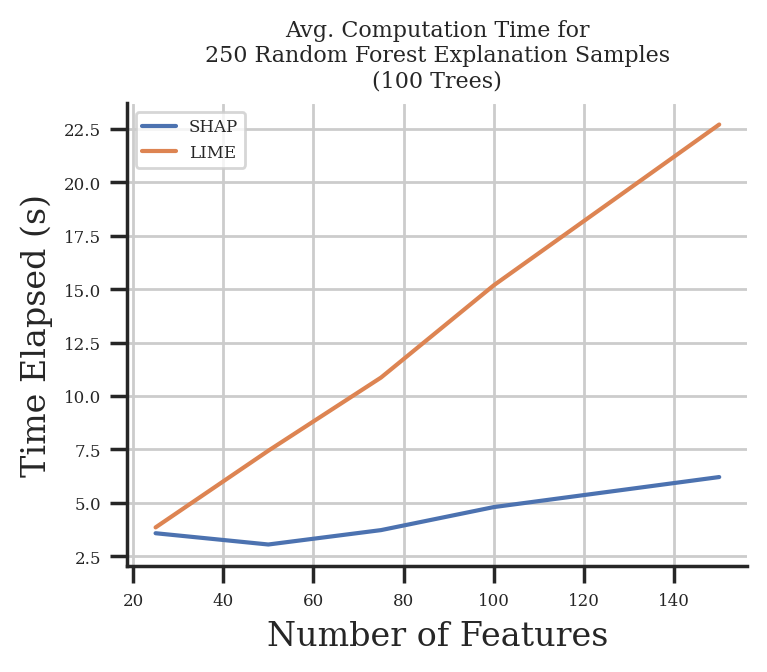

In [6]:
f, ax = plt.subplots(dpi=200, figsize=(4,3))

for key, items in elapsed.items():
    try:
        ax.plot(n_features, items, label=key.upper())
    except:
        continue

ax.legend()
ax.set_ylabel('Time Elapsed (s)')
ax.set_xlabel('Number of Features')
ax.set_title(f'Avg. Computation Time for\n{N} Random Forest Explanation Samples\n(100 Trees)')
ax.grid()

In [ ]:
#%%time
#compute_sage_(explainer, X)

In [ ]:
#%%time
#compute_lime(explainer, X)

In [ ]:
#For 5000 examples and 100 features
# LIME = 5 min, SHAP =  1min 42s

#For 1000 examples and 25 features
# LIME = , SHAP =  1min 42s